In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from ttim import *

### Theis

In [2]:
from scipy.special import exp1
def theis(r, t, T, S, Q):
    u = r ** 2 * S / (4 * T * t)
    h = -Q / (4 * np.pi * T) * exp1(u)
    return h

def theisQr(r, t, T, S, Q):
    u = r ** 2 * S / (4 * T * t)
    return -Q / (2 * np.pi) * np.exp(-u) / r

In [3]:
T = 500
S = 1e-4
t = np.logspace(-5, 0, 100)
r = 30
Q = 788

In [4]:
htheis = theis(r, t, T, S, Q)
Qrtheis = theisQr(r, t, T, S, Q)

In [5]:
ml = ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1)
w = Well(ml, tsandQ=[(0, Q)], rw=1e-5)
ml.solve()
h = ml.head(r, 0, t)
Qx, Qy = ml.disvec(r, 0, t)

self.neq  1
solution complete


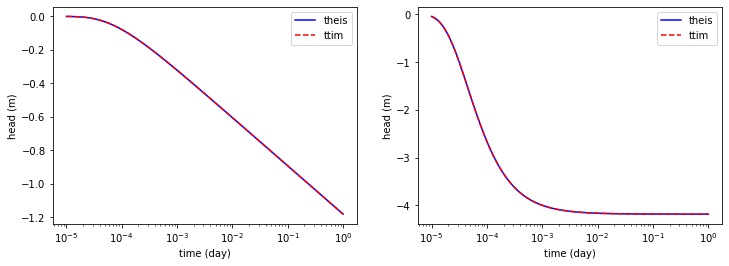

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.semilogx(t, htheis, 'b', label='theis')
plt.semilogx(t, h[0], 'r--', label='ttim')
plt.xlabel('time (day)')
plt.ylabel('head (m)')
plt.legend();
plt.subplot(122)
plt.semilogx(t, Qrtheis, 'b', label='theis')
plt.semilogx(t, Qx[0], 'r--', label='ttim')
plt.xlabel('time (day)')
plt.ylabel('head (m)')
plt.legend(loc='best');

In [7]:
def test(M=10):
    ml = ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1, M=M)
    w = Well(ml, tsandQ=[(0, Q)], rw=1e-5)
    ml.solve(silent=True)
    h = ml.head(r, 0, t)
    return htheis - h[0]

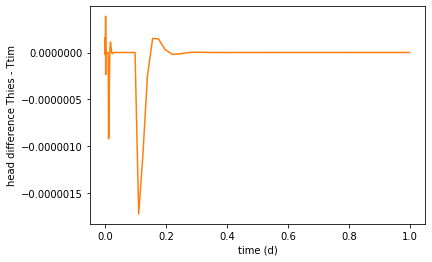

In [8]:
enumba = test(M=10)
plt.plot(t, enumba, 'C1')
plt.xlabel('time (d)')
plt.ylabel('head difference Thies - Ttim');

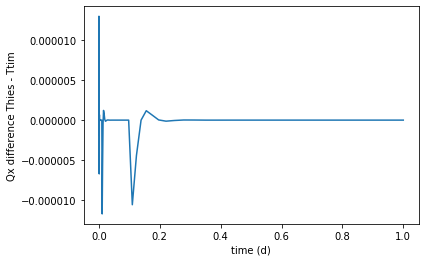

In [9]:
plt.plot(t, Qrtheis - Qx[0])
plt.xlabel('time (d)')
plt.ylabel('Qx difference Thies - Ttim');

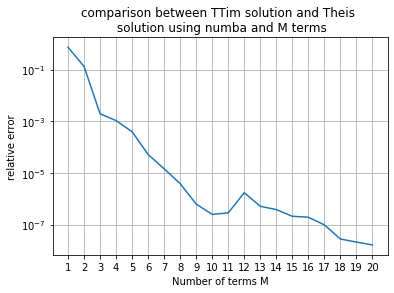

In [10]:
def compare(M=10):
    ml = ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1, M=M)
    w = Well(ml, tsandQ=[(0, Q)], rw=1e-5)
    ml.solve(silent=True)
    h = ml.head(r, 0, t)
    rmse = np.sqrt(np.mean((h[0] - htheis)**2))
    return rmse

Mlist = np.arange(1, 21)
rmse = np.zeros(len(Mlist))
for i, M in enumerate(Mlist):
    rmse[i] = compare(M)
plt.semilogy(Mlist, rmse)
plt.xlabel('Number of terms M')
plt.xticks(np.arange(1, 21))
plt.ylabel('relative error')
plt.title('comparison between TTim solution and Theis \n solution using numba and M terms')
plt.grid()

In [11]:
def volume(r, t=1):
    return -2 * np.pi * r * ml.head(r, 0, t) * ml.aq.Scoefaq[0]

from scipy.integrate import quad
quad(volume, 1e-5, np.inf)

(788.0000039400159, 2.2165658614550988e-07)

In [12]:
from scipy.special import exp1
def theis2(r, t, T, S, Q, tend):
    u1 = r ** 2 * S / (4 * T * t)
    u2 = r ** 2 * S / (4 * T * (t[t > tend] - tend))
    h = -Q / (4 * np.pi * T) * exp1(u1)
    h[t > tend] -= -Q / (4 * np.pi * T) * exp1(u2)
    return h

In [13]:
ml2 = ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=10)
w2 = Well(ml2, tsandQ=[(0, Q), (1, 0)])
ml2.solve()

self.neq  1
solution complete


In [14]:
t2 = np.linspace(0.01, 2, 100)
htheis2 = theis2(r, t2, T, S, Q, tend=1)
h2 = ml2.head(r, 0, t2)

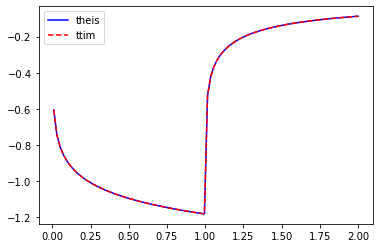

In [15]:
plt.plot(t2, htheis2, 'b', label='theis')
plt.plot(t2, h2[0], 'r--', label='ttim')
plt.legend(loc='best');

### Hantush

In [16]:
T = 500
S = 1e-4
c = 1000
t = np.logspace(-5, 0, 100)
r = 30
Q = 788

In [17]:
from scipy.integrate import quad
def integrand_hantush(y, r, lab):
    return np.exp(-y - r ** 2 / (4 * lab ** 2 * y)) / y

def hantush(r, t, T, S, c, Q, tstart=0):
    lab = np.sqrt(T * c)
    u = r ** 2 * S / (4 * T * (t - tstart))
    F = quad(integrand_hantush, u, np.inf, args=(r, lab))[0]
    return -Q / (4 * np.pi * T) * F

hantushvec = np.vectorize(hantush)

In [18]:
ml = ModelMaq(kaq=25, z=[21, 20, 0], c=[1000], Saq=S/20, topboundary='semi', tmin=1e-5, tmax=1)
w = Well(ml, tsandQ=[(0, Q)])
ml.solve()

self.neq  1
solution complete


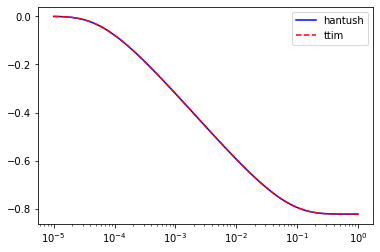

In [19]:
hhantush = hantushvec(30, t, T, S, c, Q)
h = ml.head(r, 0, t)
plt.semilogx(t, hhantush, 'b', label='hantush')
plt.semilogx(t, h[0], 'r--', label='ttim')
plt.legend(loc='best');

### Well with welbore storage

self.neq  1
solution complete
self.neq  1
solution complete


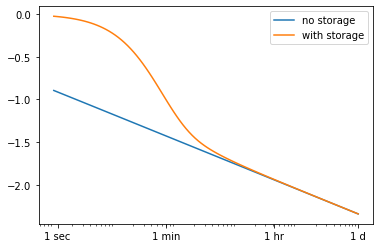

In [20]:
T = 500
S = 1e-4
t = np.logspace(-5, 0, 100)
rw = 0.3
Q = 788

ml = ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1)
w = Well(ml, rw=rw, tsandQ=[(0, Q)])
ml.solve()
hnostorage = ml.head(rw, 0, t)

ml = ModelMaq(kaq=25, z=[20, 0], Saq=S/20, tmin=1e-5, tmax=1)
w = Well(ml, rw=rw, tsandQ=[(0, Q)], rc=rw)
ml.solve()
hstorage = ml.head(rw, 0, t)

plt.semilogx(t, hnostorage[0], label='no storage')
plt.semilogx(t, hstorage[0], label='with storage')
plt.legend(loc='best')
plt.xticks([1/(24*60*60), 1/(24 * 60), 1/24, 1], ['1 sec', '1 min', '1 hr', '1 d']);

### Slug test

self.neq  1
solution complete


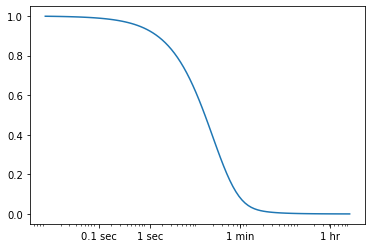

In [21]:
k = 25
H = 20
S = 1e-4 / H
t = np.logspace(-7, -1, 100)
rw = 0.2
rc = 0.2
delh = 1
ml = ModelMaq(kaq=k, z=[H, 0], Saq=S, tmin=1e-7, tmax=1)
Qslug = np.pi * rc ** 2 * delh
w = Well(ml, tsandQ=[(0, -Qslug)], rw=rw, rc=rc, wbstype='slug')
ml.solve()
h = w.headinside(t)
plt.semilogx(t, h[0])
plt.xticks([1 / (24 * 60 * 60) / 10, 1 / (24 * 60 * 60), 1 / (24 * 60), 1 / 24], 
           ['0.1 sec', '1 sec', '1 min', '1 hr']);

### Slug test in 5-layer aquifer
Well in top 2 layers

self.neq  2
solution complete


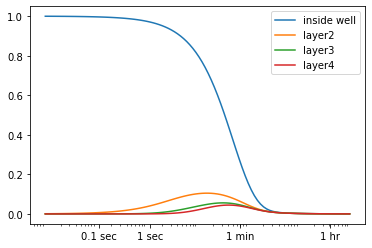

In [22]:
k = 25
H = 20
Ss = 1e-4 / H
t = np.logspace(-7, -1, 100)
rw = 0.2
rc = 0.2
delh = 1
ml = Model3D(kaq=k, z=np.linspace(H, 0, 6), Saq=Ss, tmin=1e-7, tmax=1)
Qslug = np.pi * rc**2 * delh
w = Well(ml, tsandQ=[(0, -Qslug)], rw=rw, rc=rc, layers=[0, 1], wbstype='slug')
ml.solve()
hw = w.headinside(t)
plt.semilogx(t, hw[0], label='inside well')
h = ml.head(0.2 + 1e-8, 0, t)
for i in range(2, 5):
    plt.semilogx(t, h[i], label='layer' + str(i))
plt.legend()
plt.xticks([1/(24*60*60)/10, 1/(24*60*60), 1/(24 * 60), 1/24], ['0.1 sec', '1 sec', '1 min', '1 hr']);

20 layers

self.neq  8
solution complete


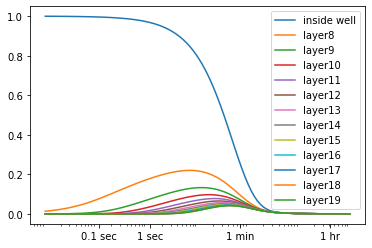

In [23]:
k = 25
H = 20
S = 1e-4 / H
t = np.logspace(-7, -1, 100)
rw = 0.2
rc = 0.2
delh = 1
ml = Model3D(kaq=k, z=np.linspace(H, 0, 21), Saq=S, tmin=1e-7, tmax=1)
Qslug = np.pi * rc**2 * delh
w = Well(ml, tsandQ=[(0, -Qslug)], rw=rw, rc=rc, layers=np.arange(8), wbstype='slug')
ml.solve()
hw = w.headinside(t)
plt.semilogx(t, hw[0], label='inside well')
h = ml.head(0.2 + 1e-8, 0, t)
for i in range(8, 20):
    plt.semilogx(t, h[i], label='layer' + str(i))
plt.legend()
plt.xticks([1/(24*60*60)/10, 1/(24*60*60), 1/(24 * 60), 1/24], ['0.1 sec', '1 sec', '1 min', '1 hr']);

### Head Well

self.neq  1
solution complete
self.neq  1
solution complete


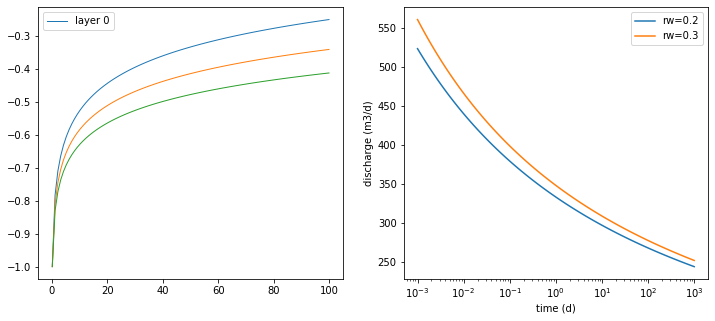

In [24]:
ml = ModelMaq(kaq=25, z=[20, 0], Saq=1e-5, tmin=1e-3, tmax=1000)
w = HeadWell(ml, tsandh=[(0, -1)], rw=0.2)
ml.solve()
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
ml.xsection(0.2, 100, 0, 0, 100, t=[0.1, 1, 10], sstart=0.2, newfig=False)
t = np.logspace(-3, 3, 100)
dis = w.discharge(t)
plt.subplot(1,2,2)
plt.semilogx(t, dis[0], label='rw=0.2')
ml = ModelMaq(kaq=25, z=[20, 0], Saq=1e-5, tmin=1e-3, tmax=1000)
w = HeadWell(ml, tsandh=[(0, -1)], rw=0.3)
ml.solve()
dis = w.discharge(t)
plt.semilogx(t, dis[0], label='rw=0.3')
plt.xlabel('time (d)')
plt.ylabel('discharge (m3/d)')
plt.legend();